# Desktop Usage and Behavior Data Analysis - August 2019 #

Purpose: We would like to begin to develop an understanding of the usage/behavior of various elements on the desktop site as we start to think about improvements we can make to the desktop experience. 

[Task](https://phabricator.wikimedia.org/T229926)

In [112]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [2]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(magrittr); library(zeallot); library(glue); library(tidyverse); library(glue); library(lubridate)
    library(scales)
})

##  Search ##

**Data questions**: 
* what percentage of users use search? 
* How many searches do users of search perform per session?

Audiences: logged-in users, logged-out users

Why this is relevant: currently search is a relatively small element on the page, and is only accessible from the top of the page (i.e. you can't perform a search if you're scrolled down, reading an article). We're curious if people have difficulty finding search, or perhaps just don't think of searching the site because they don't notice it.

Notes: Data from [searchsatisfaction](https://meta.wikimedia.org/wiki/Schema:SearchSatisfaction) eventlogging table and webrequest. Data is from August 2019 and for desktop users across all projects. Search events include both full text and autocomplete searches.


### 1. What percentage of users use search? ###

Notes: Unique users defined by client_ip and user agent.

In [3]:
# collect number of distinct users that used search
query <- 
"SELECT
  date,
  COUNT(DISTINCT CONCAT(client_ip, user_agent, query)) AS n_search,
  COUNT(DISTINCT CONCAT(client_ip, user_agent)) AS n_user,
  logged_in
FROM (
  SELECT 
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) AS date,
    access_method,
    client_ip, 
    user_agent,
    IF(x_analytics_map['loggedIn'] = '1', true, false) as logged_in,
    PARSE_URL(CONCAT('http://', uri_host, uri_path, uri_query), 'QUERY', 'search') AS query,
    PARSE_URL(CONCAT('http://', uri_host, uri_path, uri_query), 'QUERY', 'searchToken') AS searchToken
  FROM wmf.webrequest TABLESAMPLE(BUCKET 1 OUT OF 1024 ON hostname, sequence)
  WHERE year = 2019 AND month = 08
    AND webrequest_source = 'text'
    AND access_method = 'desktop'
    AND agent_type = 'user'
    AND is_pageview
    -- flag for pageviews that are search results pages
    AND page_id IS NULL
    AND (
      uri_path = '/wiki/Special:Search'
      OR (
        uri_path = '/w/index.php'
        AND (
          LENGTH(PARSE_URL(CONCAT('http://', uri_host, uri_path, uri_query), 'QUERY', 'search')) > 0
          OR LENGTH(PARSE_URL(CONCAT('http://', uri_host, uri_path, uri_query), 'QUERY', 'searchToken')) > 0
        )
      )
    )
) AS serp
GROUP BY date, logged_in;"

In [4]:
search_events_byuser <- wmf::query_hive(query)

In [5]:
search_events_byuser$date <- as.Date(search_events_byuser$date, format = "%Y-%m-%d")

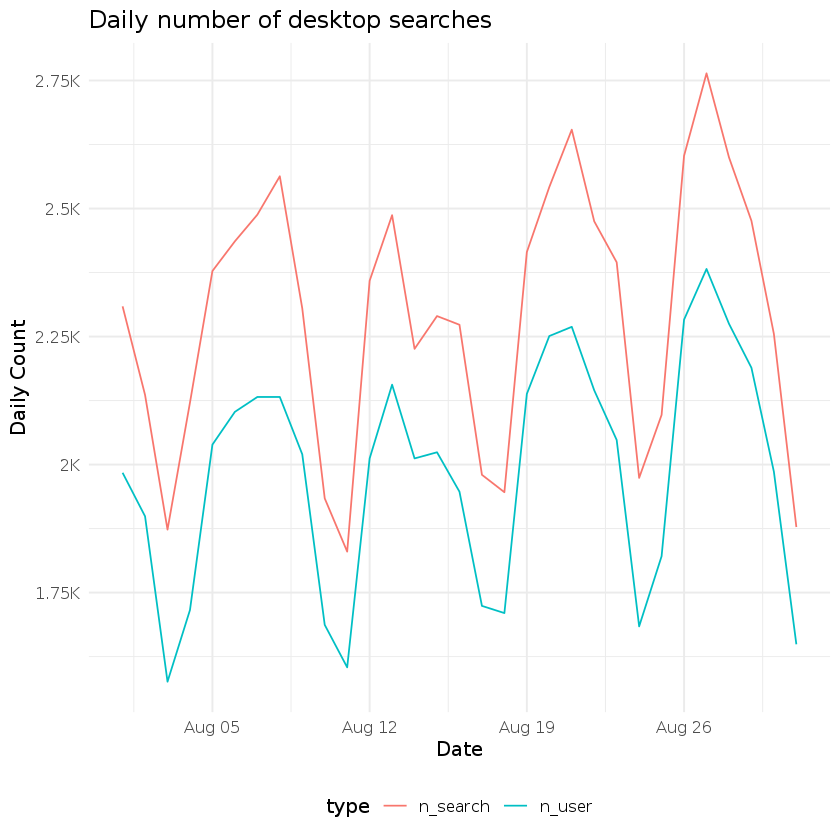

In [6]:
# Plot daily total search and sessions for August 2019
search_events_byuser_daily <- search_events_byuser %>%
  gather(type, count, n_search:n_user) %>%
group_by(date, type) %>%
summarise(count = sum(count)) %>%
  ggplot(aes(x=date, y= count, color= type)) +
  geom_line() +
  scale_x_date(name = "Date") +
  scale_y_continuous(labels = polloi::compress, name = "Daily Count") +
         labs(title = "Daily number of desktop searches") +
         wmf::theme_min() 
         
search_events_byuser_daily

In [7]:
#total number of logged in and logged out users from sample
search_events_byuser_total <- search_events_byuser %>%
group_by(logged_in) %>%
summarise(total_users = sum(n_user))

search_events_byuser_total

logged_in,total_users
<chr>,<int>
false,59139
true,2458


In [8]:
# Number of overall users (apporximated by client ip and user client)
query <-
"SELECT COUNT(DISTINCT CONCAT(client_ip, user_agent)) as n_user,
logged_in
FROM (
SELECT 
client_ip,
user_agent,
IF(x_analytics_map['loggedIn'] = '1', true, false) as logged_in
FROM wmf.webrequest TABLESAMPLE(BUCKET 1 OUT OF 1024 ON hostname, sequence)
WHERE year = 2019 and month = 8
  AND agent_type = 'user'
  AND access_method = 'desktop'
  AND webrequest_source = 'text'
  AND is_pageview
) as dataset
GROUP BY logged_in"

In [9]:
total_users_August <- wmf::query_hive(query)

In [10]:
total_users_August

n_user,logged_in
<int>,<chr>
4065669,false
90805,true


About 1.4% of logged out desktop users and about 2.7% of logged in desktop users use search based on sample from August 2019.

### 2. How many searches do users of search perform per search session?? 

In [42]:
# query for average search sessions. 
query <- "
SELECT
   CONCAT(year,'-',LPAD(month,2,'0'),'-',LPAD(day,2,'0')) as date,
  event.searchSessionId as session_id,
  sum(if(event.action='searchResultPage',1,0)) as n_search
FROM event.SearchSatisfaction
WHERE year = 2019 and month = 08 and day > 05 -- when events were logged to new schema.
AND useragent.is_bot = FALSE
AND event.action = 'searchResultPage'
group by year, month, day, event.searchSessionId
"

In [43]:
search_events_bysession <- wmf::query_hive(query)

In [45]:
search_events_bysession$date <- as.Date(search_events_bysession$date, format = "%Y-%m-%d")

In [51]:
# Find average and remove sessions with over 40 events
search_events_bysession_average <- search_events_bysession %>%
  filter(n_search < 40) %>%
  group_by(date) %>%
  summarise(average_search_bysession = mean(n_search))

head(search_events_bysession_average) 

date,average_search_bysession
<date>,<dbl>
2019-08-06,6.789426
2019-08-07,6.801644
2019-08-08,6.779381
2019-08-09,6.781527
2019-08-10,6.968016
2019-08-11,6.958233


There are an average of 6.8 searches per search session on desktop looking at all wikipedias. Note. I filtered out sessions with over 50 searches as these are likely bots. 

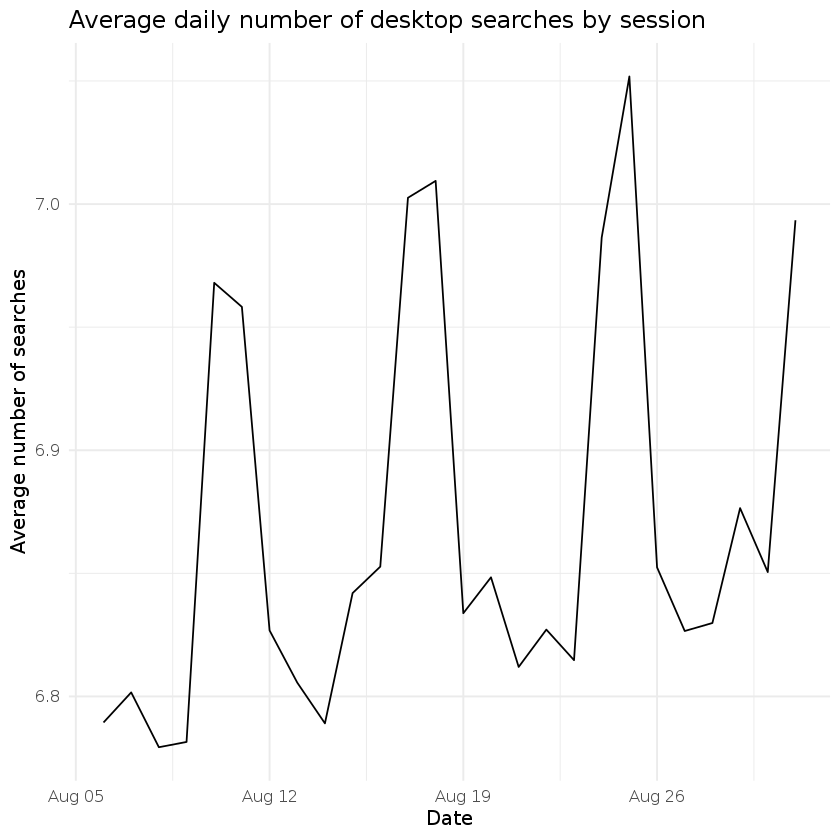

In [54]:
# Plot averaege daily sessions by search since 2019
search_events_bysession_daily_plot <- search_events_bysession_average %>%
  ggplot(aes(x=date, y= average_search_bysession)) +
  geom_line() +
  scale_x_date(name = "Date") +
  scale_y_continuous(name = "Average number of searches") +
         labs(title = "Average daily number of desktop searches by session") +
         wmf::theme_min()

search_events_bysession_daily_plot

## Main Menu (Sidebar Views) 

**Data questions**: 
* what percentage of users use links in the sidebar? 
* What is the usage for all of the various links?

**Audiences**: logged-in users, logged-out users

**Why this is relevant**: we're curious about a more modular design, wherein the main menu is collapsible. It could even act different for different audiences. Knowing how often it gets used, and by whom, will inform our thinking.

**Data Notes**:

* Analysis based on sample from webrequest July 2019 desktop data. 
* Looking at en.wiki only 
* Donate, store and wikidata links currently excluded. Unable to track as they direct to external sites. Need instrumentation.
* Note this is based on views to the pages linked in the sidebar from an internal referrer (within the wiki project). Clicks directly to links in the sidebar are not currently recorded, as a result, some of these views may include clicks from other locations on the website (It seems those views would be minimal though). 

TODO: Look into possible ways to track clicks to store and dontate links

### What is the overall usage for all of the various links?

In [ ]:
#roverall pageviews for both logged in and logged out users
query <- 
"SELECT 
SUM(IF((pageview_info['page_title'] = 'Main_Page'), 1, null)) AS main_page,
  SUM(IF((pageview_info['page_title'] = 'Portal:Contents'), 1, null)) AS contents,
  SUM(IF((pageview_info['page_title'] = 'Portal:Featured_content'), 1, null)) AS featured_content,
  SUM(IF((pageview_info['page_title'] = 'Portal:Current_events'), 1, null)) AS current_events,
  SUM(IF((pageview_info['page_title'] = 'Special:Random'), 1, null)) AS random_article,
  SUM(IF((pageview_info['page_title'] = 'Help:Contents'), 1, null)) AS help_views,
  SUM(IF((pageview_info['page_title'] = 'Wikipedia:About'), 1, null)) AS about_wikipedia,
  SUM(IF((pageview_info['page_title'] = 'Wikipedia:Community_portal'), 1, null)) AS community_portal,
  SUM(IF((pageview_info['page_title'] = 'Special:RecentChanges'), 1, null)) AS recent_changes,
  SUM(IF((pageview_info['page_title']= 'Wikipedia:Contact_us'), 1, null)) AS contact_page,
  SUM(IF((pageview_info['page_title'] LIKE 'Special:WhatLinksHere%'), 1, null)) AS what_links_here,
  SUM(IF((pageview_info['page_title'] LIKE 'Special:RecentChangesLinked%'), 1, null)) AS related_changes,
  SUM(IF((pageview_info['page_title'] = 'Wikipedia:File_Upload_Wizard'), 1, null)) AS file_upload,
  SUM(IF((pageview_info['page_title'] = 'Special:SpecialPages'), 1, null)) AS special_pages,
  SUM(IF((uri_query LIKE '%&action=info%'), 1, null)) AS page_info,
  SUM(IF((pageview_info['page_title'] = 'Special:CiteThisPage'), 1, null)) AS cite_this_page, 
  SUM(IF((pageview_info['page_title'] = 'Special:Book'), 1, null)) AS create_book,
  SUM(IF((pageview_info['page_title'] = 'Special:ElectronPdf'), 1, null)) AS download_as_pdf
FROM wmf.webrequest
WHERE year = 2019 and month = 7
  AND agent_type = 'user'
  AND pageview_info['project'] = 'en.wikipedia'
  AND access_method = 'desktop'
  AND referer_class = 'internal' --isolate to only views to these pages from within wikipedia. 
  AND is_pageview"


In [30]:
sidebar_views_overall_raw <- read.csv(file="Data/sidebar_views_overall.tsv", header=TRUE, sep="\t")

In [26]:
head(sidebar_views_overall_raw)

main_page,contents,featured_content,current_events,random_article,help_views,about_wikipedia,community_portal,recent_changes,contact_page,what_links_here,related_changes,file_upload,special_pages,page_info,cite_this_page,create_book,download_as_pdf
<int>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
11068094,424594,124742,741406,NULL,91465,125960,237826,476123,226885,843500,579563,95757,45432,123188,242384,258355,685032


In [31]:
#proportion of sidebar views

sidebar_views_overall <- sidebar_views_overall_raw %>%
  gather(sidebar_link, n_views) %>%
  mutate(proportion = (n_views / sum(n_views))) %>%
  arrange(desc(n_views))

sidebar_views_overall


sidebar_link,n_views,proportion
<chr>,<int>,<dbl>
main_page,11068094,0.675282939
what_links_here,843500,0.051463347
current_events,741406,0.045234421
download_as_pdf,685032,0.041794949
related_changes,579563,0.035360109
recent_changes,476123,0.029049061
contents,424594,0.025905191
create_book,258355,0.015762671
cite_this_page,242384,0.014788253


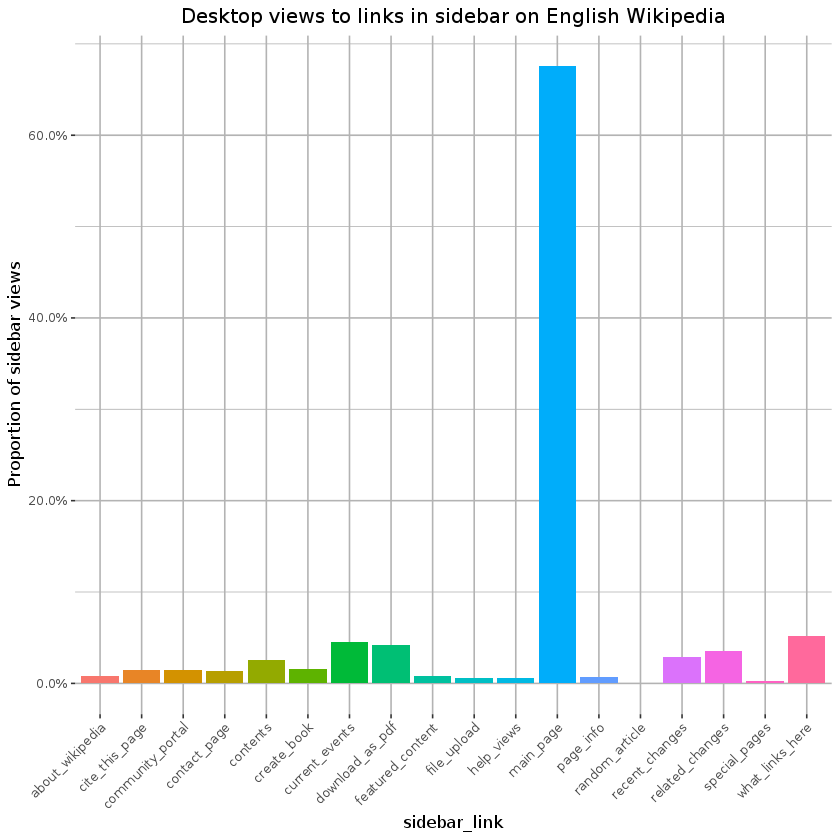

In [32]:
#plot bar chart showing usage

p <- ggplot(sidebar_views_overall, aes(x= sidebar_link, y= proportion, fill = sidebar_link)) %>%
+ geom_col(position = 'dodge') +
scale_y_continuous("Proportion of sidebar views", labels = scales::percent) +
    labs(title = "Desktop views to links in sidebar on English Wikipedia") +
    ggthemes::theme_tufte(base_size = 10, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position= "none")

ggsave("Figures/proportion_sidebar_views.png", p, width = 18, height = 9, units = "in", dpi = 150)
p


The main page is by far the most viewed sidebar linked page on desktop (about 68% of all users views to a sidebar linked page are to the main page)  followed by the what_links_here, current_events pages and download as pdf. This is for both logged in and logged out users.

Note: Random Article is recording very few events. This may be due to a bug in how it's recorded.  I'll need to investigate further

### what percentage of users use links in the sidebar?

In [43]:
#estimate of all unique users on desktop in Jul 2019 (both logged in and logged out)

query <- 
"SELECT COUNT(DISTINCT CONCAT(client_ip, user_agent)) as n_user,
logged_in
FROM (
SELECT 
client_ip,
user_agent,
IF(x_analytics_map['loggedIn'] = '1', true, false) as logged_in
FROM wmf.webrequest TABLESAMPLE(BUCKET 1 OUT OF 1024 ON hostname, sequence)
WHERE year = 2019 and month = 7
  AND agent_type = 'user'
  AND access_method = 'desktop'
  AND is_pageview
  AND webrequest_source = 'text'
 AND pageview_info['project'] = 'en.wikipedia'
) as dataset
GROUP BY logged_in"

In [22]:
unique_users_count <- read.csv(file="Data/unique_users_count.tsv", header=TRUE, sep="\t")

In [ ]:
## users who view sidebar linked page broken down by logged in status
query <- 
"SELECT COUNT(DISTINCT CONCAT(client_ip, user_agent)) as n_user_sidebar,
logged_in
FROM (
SELECT 
client_ip,
user_agent,
IF(x_analytics_map['loggedIn'] = '1', true, false) as logged_in
FROM wmf.webrequest
WHERE year = 2019 and month = 7
  AND agent_type = 'user'
  AND access_method = 'desktop'
  AND referer_class = 'internal' --isolate to only views to these pages from within wikipedia. 
  AND is_pageview
 AND pageview_info['project'] = 'en.wikipedia'
  AND (pageview_info['page_title'] IN ('Main_Page', 'Portal:Contents', 'Portal:Featured_content', 'Portal:Current_events',
  'Special:Random', 'Help:Contents', 'Wikipedia:About', 'Wikipedia:Community_portal', 'Special:RecentChanges', 'Wikipedia:Contact_us',
  'Wikipedia:File_Upload_Wizard', 'Special:SpecialPages', 'Special:CiteThisPage', 'Special:Book', 'Special:ElectronPdf') OR
      pageview_info['page_title'] LIKE '%Special:WhatLinksHere%' OR 
      pageview_info['page_title'] LIKE '%Special:RecentChangesLinked%' OR 
      uri_query LIKE '%&action=info%')
) as dataset
GROUP BY logged_in"

In [20]:
sidebar_views_user_overall_raw <- read.csv(file="Data/sidebar_views_user_overall.tsv", header=TRUE, sep="\t")

In [23]:
sidebar_views_user_overall <- merge(sidebar_views_user_overall_raw, unique_users_count, by = "logged_in", all = TRUE)

sidebar_views_byusertype <- sidebar_views_user_overall  %>%
mutate(user_pct = (n_user_sidebar/n_user_all) * 100)

sidebar_views_byusertype

logged_in,n_user_sidebar,n_user_all,user_pct
<fct>,<int>,<int>,<dbl>
,NA,NA,NA
false,11732,2038498,0.5755218
true,731,44345,1.6484384


Looking at sample data from July 2019, about 0.5% of logged out users and 1.6% of logged in desktop users clicked on a one of the pages located in the sidebar. 

In [ ]:
# Obtain user clicks to each sidebar linked page
#ran in terminal due to issues running over notebook. 

query <-
"
SELECT 
  COUNT(DISTINCT CONCAT(client_ip, user_agent)) as n_user,
  logged_in,
  sidebar_name
FROM (
  SELECT 
  client_ip,
  user_agent,
  IF(x_analytics_map['loggedIn'] = '1', true, false) as logged_in,
  (CASE
    WHEN uri_query LIKE '%&action=info%' THEN 'PageInformation' 
    WHEN pageview_info['page_title'] LIKE '%Special:WhatLinksHere%' THEN 'WhatLinksHere' 
    WHEN pageview_info['page_title'] LIKE '%Special:RecentChangesLinked%' THEN 'RelatedChanges' 
    ELSE pageview_info['page_title'] 
  END) as sidebar_name
FROM wmf.webrequest TABLESAMPLE(BUCKET 1 OUT OF 1024 ON hostname, sequence)
WHERE
year = 2019 and month = 7 
  AND agent_type = 'user'
  AND access_method = 'desktop'
  AND referer_class = 'internal' --isolate to only views to these pages from within wikipedia. 
  AND is_pageview
  AND webrequest_source = 'text'
  AND pageview_info['project'] = 'en.wikipedia'
  AND (pageview_info['page_title'] IN ('Main_Page', 'Portal:Contents', 'Portal:Featured_content', 'Portal:Current_events',
  'Special:Random', 'Help:Contents', 'Wikipedia:About', 'Wikipedia:Community_portal', 'Special:RecentChanges', 'Wikipedia:Contact_us',
  'Wikipedia:File_Upload_Wizard', 'Special:SpecialPages', 'Special:CiteThisPage', 'Special:Book', 'Special:ElectronPdf') OR
      pageview_info['page_title'] LIKE '%Special:WhatLinksHere%' OR 
      pageview_info['page_title'] LIKE '%Special:RecentChangesLinked%' OR 
      pageview_info['page_title'] LIKE '%Special:RecentChangesLinked%' OR 
      uri_query LIKE '%&action=info%')
) AS page_info
Group BY sidebar_name, logged_in
"

In [80]:
sidebar_views_user_byfeature_raw <- read.csv(file="Data/sidebar_views_users_byfeature.tsv", header=TRUE, sep= "\t")

In [121]:
#Table showing percent of all users in each group (logged in or logged out) 
#that view each page linked in the sidebar

sidebar_views_user_byfeature <- sidebar_views_user_byfeature_raw  %>%
mutate(percent_all_users = if_else(logged_in == 'false', as.numeric(n_user_sidebar)/2038498 *100, as.numeric(n_user_sidebar)/44345 * 100)) %>%
arrange(desc(percent_all_users))

sidebar_views_user_byfeature

n_user_sidebar,logged_in,sidebar_name,percent_all_users
<int>,<fct>,<fct>,<dbl>
442,true,Main_Page,0.996730184
9312,false,Main_Page,0.456806924
81,true,WhatLinksHere,0.182658699
51,true,Portal:Current_events,0.115007329
44,true,Special:RecentChanges,0.099222009
29,true,Wikipedia:File_Upload_Wizard,0.065396324
17,true,PageInformation,0.038335776
16,true,Special:ElectronPdf,0.036080731
12,true,RelatedChanges,0.027060548


##  User links in header

Questions: what percentage of users use the user links in the header? What is the usage for all of the various links?

Audiences: logged-in users, logged-out users

Why this is relevant: currently the user links take up quite a bit of space in the header. As we think of ways to tidy up the site it would be helpful to understand what the usage is like there.

Data Notes: Sample data from webrequest and pageview_hourly table for en.wiki. Data is from July 2019 and for desktop users on en.wiki.
Pages available in header vary for logged-in and logged-out users.
 

### What is the usage for all of the various links in the header?

In [ ]:
# Overall views to various header links (both logged in and logged out users)
#ran in terminal due to issues running over notebook. 
query <- 
"SELECT 
SUM(IF(page_title = 'Special:MyTalk', 1, null)) AS MyTalk,
SUM(IF(page_title = 'Special:MyContributions', 1, null)) AS MyContributions,
SUM(IF(page_title = 'Special:CreateAccount', 1, null)) AS CreateAccount,
SUM(IF(page_title = 'Special:UserLogin', 1, null)) AS UserLogin,
SUM(IF(page_title LIKE 'User:%', 1, null)) AS UserPage,
SUM(IF(page_title LIKE 'User_talk:%', 1, null)) AS User_talk,
SUM(IF(page_title LIKE 'User:%/sandbox', 1, null)) AS Sandbox,
SUM(IF(page_title = 'Special:Preferences', 1, null)) AS Preferences,
SUM(IF(page_title = 'Special:Watchlist', 1, null)) AS Watchlist,
SUM(IF(page_title LIKE 'Special:Contributions%', 1, null)) AS Contributions,
SUM(IF(page_title = 'Special:UserLogout', 1, null)) AS UserLogout
FROM wmf.pageview_hourly
WHERE year = 2019 and month = 7 
  AND agent_type = 'user'
  AND project = 'en.wikipedia'
  AND access_method = 'desktop'
  AND referer_class = 'internal' --isolate to only views to these pages from within wikipedia. 
"

In [91]:
header_views_overall_raw <- read.csv(file="Data/header_views_overall.tsv", header=TRUE, sep="\t")

In [123]:
#isolate to links viewed by logged out users

header_views_overall_loggedout <- header_views_overall_raw %>%
  gather(header_link, n_views)  %>%
  filter(header_link %in% c('mytalk', 'mycontributions','createaccount','userlogin')) %>%
   mutate(proportion = (n_views / sum(n_views))) %>%
  arrange(desc(n_views))

header_views_overall_loggedout

header_link,n_views,proportion
<chr>,<int>,<dbl>
createaccount,219392,0.52479846908
mycontributions,102760,0.24580791771
mytalk,95880,0.22935055615
userlogin,18,0.00004305705


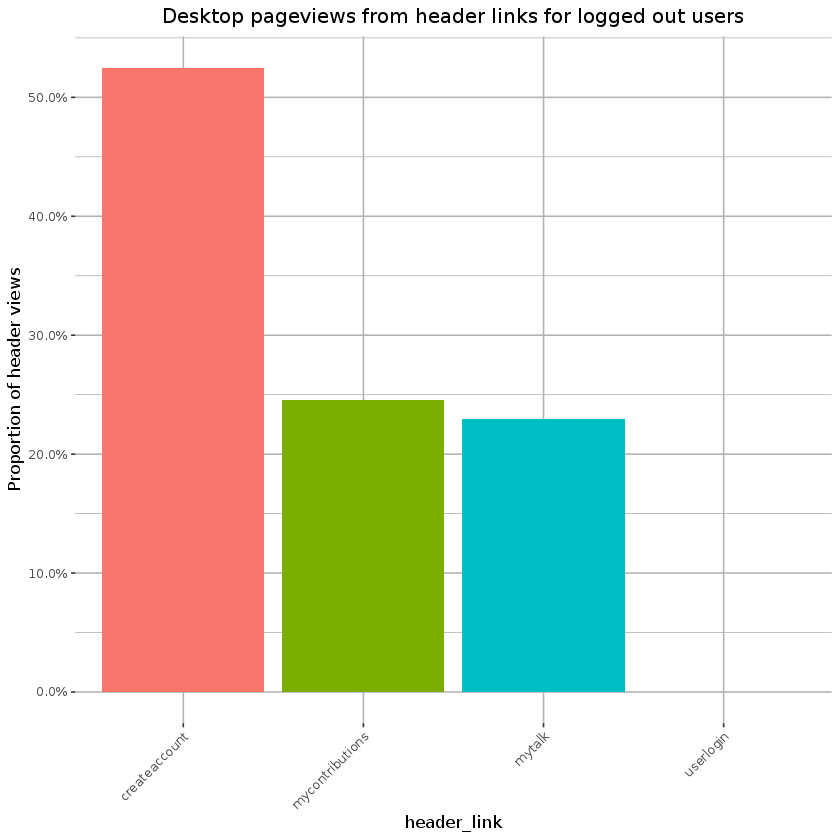

In [111]:
#plot bar chart showing usage

p <- ggplot(header_views_overall_loggedout, aes(x= header_link, y= proportion, fill = header_link)) %>%
+ geom_col(position = 'dodge') +
scale_y_continuous("Proportion of header views", labels = scales::percent) +
    labs(title = "Desktop pageviews from header links for logged out users") +
    ggthemes::theme_tufte(base_size = 10, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position= "none")

ggsave("Figures/proportion_header_views_loggedout.png", p, width = 18, height = 9, units = "in", dpi = 150)
p

he create account link is the most viewed page in the header for logged out users. It accounts for about 52% of all desktop pageviews to links in a header for logged out users. Note: There were very few views to then UserLogin page compared to the other pages in the header bar, which seems unlikely. I spent a little time digging into the data but have not yet determined if this is real behavior or a bug.

In [114]:
#isolate to links viewed by logged in users

header_views_overall_loggedin <- header_views_overall_raw %>%
  gather(header_link, n_views)  %>%
  filter(header_link %in% c('userpage','user_talk', 'sandbox','preferences','watchlist', 'contributions', 'userlogout' )) %>%
   mutate(proportion = (n_views / sum(n_views))) %>%
  arrange(desc(n_views))

header_views_overall_loggedin

header_link,n_views,proportion
<chr>,<int>,<dbl>
userpage,1280851,0.332278703
user_talk,1023740,0.265578900
contributions,870312,0.225776568
watchlist,511455,0.132681791
sandbox,83960,0.021780925
userlogout,55291,0.014343606
preferences,29140,0.007559506


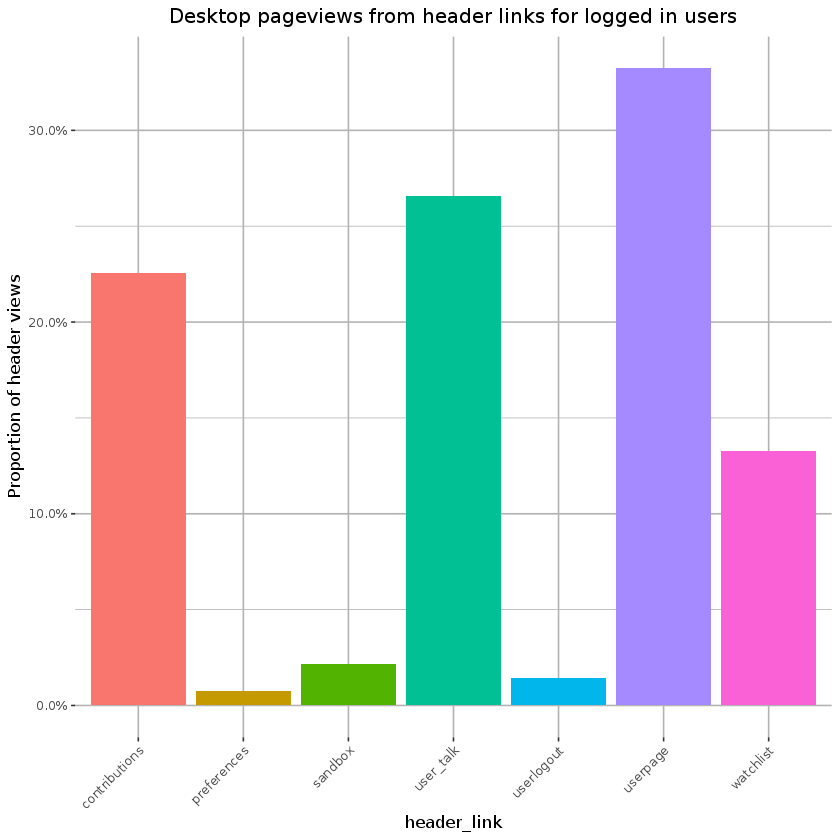

In [115]:
#plot bar chart showing usage

p <- ggplot(header_views_overall_loggedin, aes(x= header_link, y= proportion, fill = header_link)) %>%
+ geom_col(position = 'dodge') +
scale_y_continuous("Proportion of header views", labels = scales::percent) +
    labs(title = "Desktop pageviews from header links for logged in users") +
    ggthemes::theme_tufte(base_size = 10, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position= "none")

ggsave("Figures/proportion_header_views_loggedin.png", p, width = 18, height = 9, units = "in", dpi = 150)
p

The user page, user talk page and contributions pages are the most viewed pages in the header for logged in users. 

### What percentage of users use the user links in the header?

In [ ]:
## Overall for logged out users. Obtaining sample from the webrequest table. 
query <- 
"SELECT COUNT(DISTINCT CONCAT(client_ip, user_agent)) as n_user
FROM (
SELECT 
client_ip,
user_agent
FROM wmf.webrequest TABLESAMPLE(BUCKET 1 OUT OF 1024 ON hostname, sequence)
WHERE year = 2019 and month = 7
  AND agent_type = 'user'
  AND access_method = 'desktop'
  AND referer_class = 'internal' --isolate to only views to these pages from within wikipedia. 
 AND webrequest_source = 'text'
  AND is_pageview
AND x_analytics_map['loggedIn'] is NULL  
 AND pageview_info['project'] = 'en.wikipedia'
  AND pageview_info['page_title'] IN ('Special:MyTalk', 'Special:MyContributions','Special:CreateAccount','Special:UserLogin') 
) as page_info"


** Logged Out Users
* Logged out users that click link in sidebar out of selected sample: 891
* Percentage of logged in users that click header link: Only about 0.04% of logged out users view one of the pages found in the header. 

In [ ]:
## Overall for logged in users
query <- 
"SELECT COUNT(DISTINCT CONCAT(client_ip, user_agent)) as n_user
FROM (
SELECT 
client_ip,
user_agent,
FROM wmf.webrequest TABLESAMPLE(BUCKET 1 OUT OF 1024 ON hostname, sequence)
WHERE year = 2019 and month = 7
  AND agent_type = 'user'
  AND access_method = 'desktop'
  AND referer_class = 'internal' --isolate to only views to these pages from within wikipedia. 
 AND webrequest_source = 'text'
  AND is_pageview
AND x_analytics_map['loggedIn'] is NOT NULL  
 AND pageview_info['project'] = 'en.wikipedia'
  AND (pageview_info['page_title'] IN ('Special:Preferences', 'Special:Watchlist','Special:UserLogout') 
OR
      pageview_info['page_title'] LIKE 'User:%' OR 
      pageview_info['page_title'] LIKE 'User_talk:%' OR 
      pageview_info['page_title'] LIKE 'User:%/sandbox' OR
      pageview_info['page_title'] LIKE 'Special:Contributions%')
)as page_info"

** Logged In Users
* Logged in users that click header link out of selected sample: 3198
* Percentage of logged in users that click header link:  7.2% 

A higher percentage of logged in users click on a link in the header compared to logged out.

In [ ]:
## By Feature for Logged Out Users

query <-
"SELECT 
  COUNT(DISTINCT CONCAT(client_ip, user_agent)) as n_user,
  header_name
FROM (
  SELECT 
  client_ip,
  user_agent,
  pageview_info['page_title'] as sidebar_name
FROM wmf.webrequest TABLESAMPLE(BUCKET 1 OUT OF 1024 ON hostname, sequence)
WHERE
year = 2019 and month = 7 
  AND agent_type = 'user'
  AND access_method = 'desktop'
  AND referer_class = 'internal' --isolate to only views to these pages from within wikipedia. 
  AND is_pageview
  AND x_analytics_map['loggedIn'] is NULL  
  AND webrequest_source = 'text'
  AND pageview_info['project'] = 'en.wikipedia'
  AND pageview_info['page_title'] IN ('Special:MyTalk', 'Special:MyContributions','Special:CreateAccount','Special:UserLogin') 
) AS page_info
Group BY sidebar_name
"


In [93]:
header_views_loggedout_bylink_raw <- read.csv(file="Data/header_views_loggedout_bylink.tsv", header=TRUE, sep= "\t")

In [96]:
header_views_loggedout_bylink <- header_views_loggedout_bylink_raw  %>%
mutate(user_pct = as.numeric(n_user)/2038498 *100) %>%
arrange(desc(user_pct))

header_views_loggedout_bylink


n_user,sidebar_name,user_pct
<int>,<fct>,<dbl>
564,Special:CreateAccount,0.02766742965
252,Special:MyTalk,0.01236204303
125,Special:MyContributions,0.00613196579
1,Special:UserLogin,0.00004905573


In [ ]:
## By Feature for Logged In Users

query <-
"SELECT 
  COUNT(DISTINCT CONCAT(client_ip, user_agent)) as n_user,
  header_name
FROM (
  SELECT 
  client_ip,
  user_agent,
  (CASE 
    WHEN pageview_info['page_title'] LIKE 'User:%' THEN 'User' 
    WHEN pageview_info['page_title'] LIKE 'User_talk:%' THEN 'User_talk' 
    WHEN pageview_info['page_title'] LIKE 'User:%/sandbox' THEN 'Sandbox' 
    WHEN pageview_info['page_title'] LIKE 'Special:Contributions%' THEN 'Special:Contributions'
    ELSE pageview_info['page_title'] 
  END) as header_name
FROM wmf.webrequest TABLESAMPLE(BUCKET 1 OUT OF 1024 ON hostname, sequence)
WHERE
year = 2019 and month = 7
  AND agent_type = 'user'
  AND access_method = 'desktop'
  AND referer_class = 'internal' --isolate to only views to these pages from within wikipedia. 
  AND is_pageview
  AND x_analytics_map['loggedIn'] is NOT NULL  
  AND webrequest_source = 'text'
  AND pageview_info['project'] = 'en.wikipedia'
 AND (pageview_info['page_title'] IN ('Special:Preferences', 'Special:Watchlist','Special:UserLogout') 
OR
      pageview_info['page_title'] LIKE 'User:%' OR 
      pageview_info['page_title'] LIKE 'User_talk:%' OR 
      pageview_info['page_title'] LIKE 'User:%/sandbox' OR
      pageview_info['page_title'] LIKE 'Special:Contributions%') 
) AS page_info
Group BY header_name
"

In [97]:
header_views_loggedin_bylink_raw <- read.csv(file="Data/header_views_loggedin_bylink.tsv", header=TRUE, sep= "\t")

In [98]:
header_views_loggedin_bylink <- header_views_loggedin_bylink_raw  %>%
mutate(user_pct = as.numeric(n_user)/44345 *100) %>%
arrange(desc(user_pct))

header_views_loggedin_bylink

n_user,header_name,user_pct
<int>,<fct>,<dbl>
975,User,2.198669523
866,Special:Contributions,1.952869546
814,Special:Watchlist,1.835607171
767,User_talk,1.729620025
51,Special:Preferences,0.115007329
3,Special:UserLogout,0.006765137


## Language Links

Data questions: what percentage of users use language links?

Audiences: logged-in users, logged-out users

Why this is relevant: currently you have to scroll in order to find the language links. We're wondering if a more prominent location, perhaps closer to the article context itself, would make it easier for users to find.

Data Notes: Data from [wmf.interlaguage_navigation](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/Interlanguage). Includes data for all projects and from July 2019.

Due to available intrumentation, I am unable to show %of users with available dataset but I can show % of project views instead. See below. 

In [147]:
#By project looking by the source of request (not target)
query <- 
"
SELECT
  navigation_count.project as project,
  (navigation_count_total / view_count_total) *100 as percent_interlanguage_navigation
FROM (
SELECT 
    concat(previous_project, '.', project_family) as project,
    sum(navigation_count) as navigation_count_total
    from wmf.interlanguage_navigation
    where date > '2019-06-31' 
    AND date < '2019-08-01'
    group by project_family, previous_project
        ) as navigation_count
INNER JOIN
(SELECT project,
sum(view_count) as view_count_total
FROM wmf.projectview_hourly
WHERE concat(year, '-', lpad(month, 2, '0'), '-', lpad(day, 2, '0')) between '2019-06-31' and '2019-08-01'
and access_method = 'desktop'
and agent_type = 'user'
group by project
) as projectview 
on navigation_count.project = projectview.project
ORDER by percent_interlanguage_navigation DESC LIMIT 5000"


In [148]:
interlanguage_clicks_byproject <- wmf::query_hive(query)

In [149]:
head(interlanguage_clicks_byproject, 10)

project,percent_interlanguage_navigation
<chr>,<dbl>
kg.wikipedia,10.363773
cv.wikipedia,9.953629
gd.wikipedia,9.470999
pa.wikipedia,9.375662
zh-min-nan.wikipedia,9.265733
arc.wikipedia,9.254850
ga.wikipedia,9.221888
nap.wikipedia,9.097672
ce.wikipedia,9.080891


In [153]:
#Views for top sized_wikis
interlanguage_clicks_byproject_topwikis <- interlanguage_clicks_byproject %>%
 filter(project %in% c('en.wikipedia', 'es.wikipedia', 'de.wikipedia', 'ja.wikipedia',
                    'fr.wikipedia', 'ru.wikipedia', 'it.wikipedia', 'zh.wikipedia')) %>%
  arrange(desc(percent_interlanguage_navigation))

interlanguage_clicks_byproject_topwikis


project,percent_interlanguage_navigation
<chr>,<dbl>
fr.wikipedia,0.3858005
de.wikipedia,0.3707331
it.wikipedia,0.3147767
ja.wikipedia,0.2740005
zh.wikipedia,0.2383240
en.wikipedia,0.2179289
es.wikipedia,0.2024851
ru.wikipedia,0.1820905


In [133]:
#overall across all projects
query <- 
"
SELECT
  SUM(navigation_count_total) as navigation_count_total,
  SUM(view_count_total) as view_count_total
FROM (
SELECT 
    concat(previous_project, '.', project_family) as project,
    sum(navigation_count) as navigation_count_total
FROM wmf.interlanguage_navigation
WHERE date >= '2019-07-01' 
    AND date <= '2019-07-31'
    group by project_family, previous_project
    ) as navigation_count
INNER JOIN
(
SELECT project,
  sum(view_count) as view_count_total
FROM wmf.projectview_hourly
WHERE 
  concat(year, '-', lpad(month, 2, '0'), '-', lpad(day, 2, '0')) between '2019-07-01' and '2019-07-31'
  and access_method = 'desktop'
  and agent_type = 'user'
  group by project
) as projectview
on navigation_count.project = projectview.project"

In [134]:
interlanguage_clicks_overall <- wmf::query_hive(query)

In [135]:
interlanguage_clicks_overall

navigation_count_total,view_count_total
<int>,<dbl>
23948360,6166994793


About 0.39% of all pageviews from desktop are interlanguage navigation. 

## Table of contents

Table of Contents clicks are not recorded by the client or server side. I'll do a little more asking with the team to confirm if there is a way to use the uri_path. 